# Detect total amount TTC on receipts


In [1]:
!sudo apt install tesseract-ocr -y
!pip install datasets evaluate seqeval pytesseract opencv-python optuna

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.


## Importing the libraries



In [2]:
from datasets import load_dataset
import json
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import (
    AutoProcessor, LayoutLMv3ForTokenClassification, AutoModelForTokenClassification,
    TrainingArguments, Trainer, default_data_collator
)
from evaluate import load
import numpy as np
import torch
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import random
from itertools import product
import itertools
import warnings

In [3]:
warnings.filterwarnings("ignore")

## CORD Dataset

### Loading the cord dataset

In [4]:
# Loading the CORD Dataset using load_dataset
dataset = load_dataset('naver-clova-ix/cord-v2')

### Extracting the training, valdation and testing dataset

In [5]:
# Training dataset
train = dataset['train']
# Validation Dataset
valid = dataset['validation']
# Testing Dataset
test = dataset['test']

In [6]:
print(f'Train dataset shape: {train.shape}')
print(f'Valid dataset shape: {valid.shape}')
print(f'Test dataset shape: {test.shape}')

Train dataset shape: (800, 2)
Valid dataset shape: (100, 2)
Test dataset shape: (100, 2)


In [7]:
# Printing the first element of the training dataset
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=864x1296>,
 'ground_truth': '{"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": 

**As we can see from the output above, our datasets have the shape (num_element, 2), where each element contains a picture and its corresponding OCR parsing.**

In [8]:
# Extracting the OCR parsing (ground truth) of the first element from our training dataset
sample_data = train[0]['ground_truth']
sample_data_json = json.loads(sample_data)
# Displaying the keys of the ground truth data for the first element
sample_data_json.keys()

dict_keys(['gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'])

In [9]:
categories = [item['category'] for item in sample_data_json.get('valid_line', []) if 'category' in item]
# Displaying all the possible categories for the words in the dataset
categories

['menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'menu.cnt',
 'menu.nm',
 'menu.price',
 'sub_total.subtotal_price',
 'sub_total.service_price',
 'sub_total.tax_price',
 'sub_total.etc',
 'total.total_price']

## Preparing the Data

**In the OCR parsing (ground truth) of each picture, the valid_line section contains the coordinates for the bounding box of each word along with its category. Since the goal is to detect the total amount on the receipt, I decided to classify the words into two labels: either the word represents the total price or it does not. The cell below performs this transformation.**

In [10]:
# Creating the new label list as explained before
label_list = ['other', 'total.total_price']
# Mapping of each label with its id (0 for the label 'other' or 1 for the label 'total.total_price')
id2label = {k: v for k, v in enumerate(label_list)}
label2id = {v: k for k, v in enumerate(label_list)}

**Now, we need to transform our data so that it can be suitable for input into the LayoutLMv3 model. To achieve this, we need to extract from the ground truth of each receipt image: the words, their corresponding bounding boxes, and the word labels. This information will be processed using the LayoutLMv3 Processor, which will then prepare the data for input into the LayoutLMv3 model.**

In [11]:
def prepare_data(image, gt):
  """
  Prepares the data by extracting words, their bounding boxes, and labels from the ground truth data.

  Args:
    image (PIL.Image): The image data.
    gt (dict): The ground truth data containing annotations about text and bounding boxes.

  Returns:
    words (list): A list of words extracted from the ground truth.
    bboxes (list): A list of bounding boxes corresponding to each word.
    word_labels (list): A list of labels for each word.
  """

  words, bboxes, word_labels = [], [], []
  height, width = gt['meta']['image_size']['height'], gt['meta']['image_size']['width']

  # Iterating over each valid line in the ground truth data
  for elem in gt['valid_line']:
    # Assigning label based on category; 'total.total_price' gets a special label, others are labeled as 'other'
    label = elem['category'] if elem['category'] == 'total.total_price' else 'other'
    for word in elem['words']:
      if len(word['text']) > 0:
        # Calculating the bounding box coordinates in 1000x1000 normalized format
        bbox = [int(1000 * (word['quad']['x1'] / width)), int(1000 * (word['quad']['y1'] / height)), \
                int(1000 * (word['quad']['x3'] / width)), int(1000 * (word['quad']['y3'] / height))]

        # Filtering out invalid bounding boxes
        if min(bbox) < 0 or max(bbox) > 1000 or ((bbox[2] - bbox[0]) < 0) or ((bbox[3] - bbox[1]) < 0):
          continue

        words.append(word['text'])
        bboxes.append(bbox)
        word_labels.append(label2id[label])

  return words, bboxes, word_labels

**After obtaining the words, bounding boxes, and word labels for each image, I created a CustomDataset class. This class prepares the data for the model's input by processing it through the model's processor.**

In [12]:
class CustomDataset(Dataset):
  def __init__(self, data, processor):
    """
    Initialize the dataset.

    Args:
        data (DataFrame): The dataset containing the image and ground truth information.
        processor (AutoProcessor): The LayoutLMv3 processor used to preprocess the images and their labels.
    """
    self.data = data
    self.processor = processor

  def __len__(self):
    """
    Return the total number of samples in the dataset.

    Returns:
        int: Number of rows in the dataset.
    """
    return self.data.num_rows

  def __getitem__(self, idx):
    """
    Get a sample from the dataset.

    Args:
        idx (int): The index of the sample to retrieve.

    Returns:
        dict: A dictionary containing the preprocessed inputs ready for the model.
    """
    image = self.data[idx]['image']
    ground_truth = json.loads(self.data[idx]['ground_truth'])
    words, bboxes, word_labels = prepare_data(image, ground_truth)
    # Preprocess the image and its associated data using the processor
    inputs = self.processor(image, words, boxes=bboxes, word_labels=word_labels, truncation=True, padding='max_length', return_tensors='pt')
    return {key: value.squeeze() for key, value in inputs.items()}

In [13]:
# Loading the LayoutLMv3 Processor
processor = AutoProcessor.from_pretrained('microsoft/layoutlmv3-base', apply_ocr=False)

In [14]:
# The train, validation, test datasets prepared for the LayoutLMv3 model
train_dataset = CustomDataset(train, processor)
valid_dataset = CustomDataset(valid, processor)
test_dataset = CustomDataset(test, processor)

In [15]:
# THE CODE IN THIS CELL IS TAKEN FROM THE LAYOUTLMV3 DEMO NOTEBOOK
metric = load("seqeval")
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Training Phase

### Hyperparameter tuning


**The cell below aims to find the best learning rate and batch size for training our model using the validation dataset**

**I chose the f1 score as the metric for choosing the best hyparameters because it balances the model’s precision in identifying the total price and recall in detecting all relevant instances, ensuring accurate identification of the TTC amount on receipts.**

In [16]:
learning_rates = [1e-5, 5e-5, 1e-4]
batch_sizes = [2, 4]

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(learning_rates, batch_sizes))

# Function to run the model training and evaluation for each combination
def run_grid_search(param_combo):
  learning_rate, batch_size = param_combo
  # Loading the LayoutLMv3 Model
  model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', id2label=id2label, label2id=label2id)

  # Define training arguments
  training_args = TrainingArguments(
    output_dir=f"layoutlmv3-gridsearch",
    max_steps=1000,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
  )

  # Initialize Trainer
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
  )

  # Train the model
  trainer.train()

  # Evaluate the model
  metrics = trainer.evaluate()
  return learning_rate, batch_size, metrics["eval_f1"]

# Perform grid search
best_score = -np.inf
best_params = None
results = []

for param_combo in param_combinations:
  learning_rate, batch_size, eval_f1 = run_grid_search(param_combo)
  results.append((learning_rate, batch_size, eval_f1))

  if eval_f1 > best_score:
    best_score = eval_f1
    best_params = (learning_rate, batch_size)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wardi (awsaaf_rhoban). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.030061,0.893836,0.922261,0.907826,0.991308
200,No log,0.008790,0.978873,0.982332,0.980600,0.997713
300,No log,0.013752,0.971831,0.975265,0.973545,0.996340
400,No log,0.006804,0.965157,0.978799,0.971930,0.997255
500,0.071000,0.009249,0.965517,0.989399,0.977312,0.997713
600,0.071000,0.008155,0.965517,0.989399,0.977312,0.997713
700,0.071000,0.009394,0.965517,0.989399,0.977312,0.997713
800,0.071000,0.010216,0.978799,0.978799,0.978799,0.997713
900,0.071000,0.002665,0.982456,0.989399,0.985915,0.998628
1000,0.017000,0.004731,0.989324,0.982332,0.985816,0.998170


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.018905,0.918367,0.954064,0.935875,0.994053
200,No log,0.009946,0.968641,0.982332,0.975439,0.997255
300,No log,0.008215,0.989399,0.989399,0.989399,0.997255
400,No log,0.007845,0.972125,0.985866,0.978947,0.997713
500,0.049900,0.015019,0.972125,0.985866,0.978947,0.996798
600,0.049900,0.015036,0.972125,0.985866,0.978947,0.996798
700,0.049900,0.012178,0.972125,0.985866,0.978947,0.996798
800,0.049900,0.013999,0.972125,0.985866,0.978947,0.996798
900,0.049900,0.015102,0.965278,0.982332,0.973730,0.995883
1000,0.011300,0.016617,0.972125,0.985866,0.978947,0.996798


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.054243,0.947368,0.954064,0.950704,0.993596
200,No log,0.034079,0.935154,0.968198,0.951389,0.993138
300,No log,0.023205,0.971930,0.978799,0.975352,0.995425
400,No log,0.026051,0.951220,0.964664,0.957895,0.995883
500,0.066700,0.017510,0.975352,0.978799,0.977072,0.995883
600,0.066700,0.024586,0.972125,0.985866,0.978947,0.996340
700,0.066700,0.010508,0.979094,0.992933,0.985965,0.997255
800,0.066700,0.009469,0.979094,0.992933,0.985965,0.998170
900,0.066700,0.010251,0.979094,0.992933,0.985965,0.998170
1000,0.020900,0.008325,0.989474,0.996466,0.992958,0.998628


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.021242,0.941980,0.975265,0.958333,0.994511
200,No log,0.001554,0.992958,0.996466,0.994709,0.999543
300,No log,0.001649,1.000000,1.000000,1.000000,1.000000
400,No log,0.005641,0.971930,0.978799,0.975352,0.997255
500,0.043100,0.006207,0.979094,0.992933,0.985965,0.998170
600,0.043100,0.003306,0.989474,0.996466,0.992958,0.999085
700,0.043100,0.004627,0.979094,0.992933,0.985965,0.998628
800,0.043100,0.005134,0.989474,0.996466,0.992958,0.998628
900,0.043100,0.016476,0.972222,0.989399,0.980736,0.997255
1000,0.008100,0.016255,0.972222,0.989399,0.980736,0.996798


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.340328,0.020000,0.007067,0.010444,0.903477
200,No log,0.338263,0.020000,0.007067,0.010444,0.903477
300,No log,0.338633,0.020000,0.007067,0.010444,0.903477
400,No log,0.339098,0.020000,0.007067,0.010444,0.903477
500,0.333800,0.338415,0.020000,0.007067,0.010444,0.903477
600,0.333800,0.342966,0.020000,0.007067,0.010444,0.903477
700,0.333800,0.338373,0.020000,0.007067,0.010444,0.903477
800,0.333800,0.338450,0.020000,0.007067,0.010444,0.903477
900,0.333800,0.339521,0.020000,0.007067,0.010444,0.903477
1000,0.330000,0.338460,0.020000,0.007067,0.010444,0.903477


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.039222,0.894915,0.932862,0.913495,0.991766
200,No log,0.016039,0.893688,0.950530,0.921233,0.993596
300,No log,0.018336,0.951557,0.971731,0.961538,0.995425
400,No log,0.019515,0.971930,0.978799,0.975352,0.995883
500,0.055300,0.014656,0.978947,0.985866,0.982394,0.996798
600,0.055300,0.015337,0.961672,0.975265,0.968421,0.995883
700,0.055300,0.016034,0.978947,0.985866,0.982394,0.996340
800,0.055300,0.014227,0.985866,0.985866,0.985866,0.997255
900,0.055300,0.013510,0.975439,0.982332,0.978873,0.996798
1000,0.010000,0.016348,0.985866,0.985866,0.985866,0.997255


In [17]:
# Output the results
print("Grid Search Results:")
for lr, bs, f1 in results:
    print(f"Learning Rate: {lr}, Batch Size: {bs}, F1 Score: {f1:.4f}")
lr, bs = best_params[0], best_params[1]
print(f"Best parameters: Learning Rate: {best_params[0]}, Batch Size: {best_params[1]}, F1 Score: {best_score:.4f}")

Grid Search Results:
Learning Rate: 1e-05, Batch Size: 2, F1 Score: 0.9858
Learning Rate: 1e-05, Batch Size: 4, F1 Score: 0.9789
Learning Rate: 5e-05, Batch Size: 2, F1 Score: 0.9930
Learning Rate: 5e-05, Batch Size: 4, F1 Score: 0.9860
Learning Rate: 0.0001, Batch Size: 2, F1 Score: 0.0104
Learning Rate: 0.0001, Batch Size: 4, F1 Score: 0.9859
Best parameters: Learning Rate: 5e-05, Batch Size: 2, F1 Score: 0.9930


### Training the Model

In [32]:
# Loading the LayoutLMv3 Model
best_model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', id2label=id2label, label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Training args using the output of hyperparameter tuning phase
training_args = TrainingArguments(output_dir='layoutlmv3-finetuned',
                                  max_steps=1000,
                                  per_device_train_batch_size=bs,
                                  per_device_eval_batch_size=bs,
                                  learning_rate=lr,
                                  evaluation_strategy='steps',
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='f1')

In [20]:
trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [21]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.054243,0.947368,0.954064,0.950704,0.993596
200,No log,0.034079,0.935154,0.968198,0.951389,0.993138
300,No log,0.023205,0.971930,0.978799,0.975352,0.995425
400,No log,0.026051,0.951220,0.964664,0.957895,0.995883
500,0.066700,0.017510,0.975352,0.978799,0.977072,0.995883
600,0.066700,0.024586,0.972125,0.985866,0.978947,0.996340
700,0.066700,0.010508,0.979094,0.992933,0.985965,0.997255
800,0.066700,0.009469,0.979094,0.992933,0.985965,0.998170
900,0.066700,0.010251,0.979094,0.992933,0.985965,0.998170
1000,0.020900,0.008325,0.989474,0.996466,0.992958,0.998628


TrainOutput(global_step=1000, training_loss=0.04377439880371094, metrics={'train_runtime': 612.3125, 'train_samples_per_second': 3.266, 'train_steps_per_second': 1.633, 'total_flos': 527187062784000.0, 'train_loss': 0.04377439880371094, 'epoch': 2.5})

In [22]:
trainer.evaluate()

{'eval_loss': 0.008324770256876945,
 'eval_precision': 0.9894736842105263,
 'eval_recall': 0.9964664310954063,
 'eval_f1': 0.9929577464788732,
 'eval_accuracy': 0.9986276303751144,
 'eval_runtime': 15.2283,
 'eval_samples_per_second': 6.567,
 'eval_steps_per_second': 3.283,
 'epoch': 2.5}

## Testing Phase

**After training our model, we are going to test it using the test dataset**



In [35]:
# Loading the model that had the best f1 score in the validation phase
model_test = AutoModelForTokenClassification.from_pretrained('/kaggle/working/layoutlmv3-finetuned/checkpoint-1000')

In [36]:
test_args = TrainingArguments(
    output_dir = 'test',
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 2,
    dataloader_drop_last = False
)

In [37]:
trainer = Trainer(model = model_test,
                  args = test_args,
                  compute_metrics = compute_metrics)

In [38]:
test_predictions, test_labels, test_metrics = trainer.predict(test_dataset)

In [39]:
test_metrics

{'test_loss': 0.02947918325662613,
 'test_model_preparation_time': 0.0044,
 'test_precision': 0.9605734767025089,
 'test_recall': 0.9745454545454545,
 'test_f1': 0.9675090252707582,
 'test_accuracy': 0.9961767204757859,
 'test_runtime': 15.6355,
 'test_samples_per_second': 6.396,
 'test_steps_per_second': 3.198}

### Plotting the result of the model for one of the images in the testing dataset

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
def unnormalize_box(bbox, width, height):
  """
  Converts the normalized bounding box coordinates back to their original scale based on image dimensions.

  Args:
      bbox (list): A list of normalized bounding box coordinates [x_min, y_min, x_max, y_max].
      width (int): The original width of the image.
      height (int): The original height of the image.

  Returns:
      list: A list of unnormalized bounding box coordinates [x_min, y_min, x_max, y_max] in pixels.
  """
  return [
      int(width * (bbox[0] / 1000)),
      int(height * (bbox[1] / 1000)),
      int(width * (bbox[2] / 1000)),
      int(height * (bbox[3] / 1000)),
  ]

**The objective of the few cells below is to plot the first test image with the bounding box of the words which their predicted label is 'total.total_price'**

In [42]:
# Taking the first image of the test dataset
test_sample = test[0]
image = test_sample['image']
img_width, img_height = image.size
image_idx = json.loads(test_sample['ground_truth'])['meta']['image_id']
sample = test_dataset[image_idx]

In [43]:
# Taking the necessary variables to give to the trained model
input_ids = sample['input_ids'].unsqueeze(0).to(device)
bbox = sample['bbox'].unsqueeze(0).to(device)
pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
labels = sample['labels']

# Predicting the labels
with torch.no_grad():
  output = model_test(input_ids=input_ids, attention_mask=attention_mask, bbox=bbox, pixel_values=pixel_values)
  prediction = output.logits.argmax(-1).squeeze().tolist()

In [44]:
ground_truth_labels = labels.numpy()
predicted_labels = prediction

ground_truth_bboxes = sample['bbox'].squeeze().cpu().numpy()

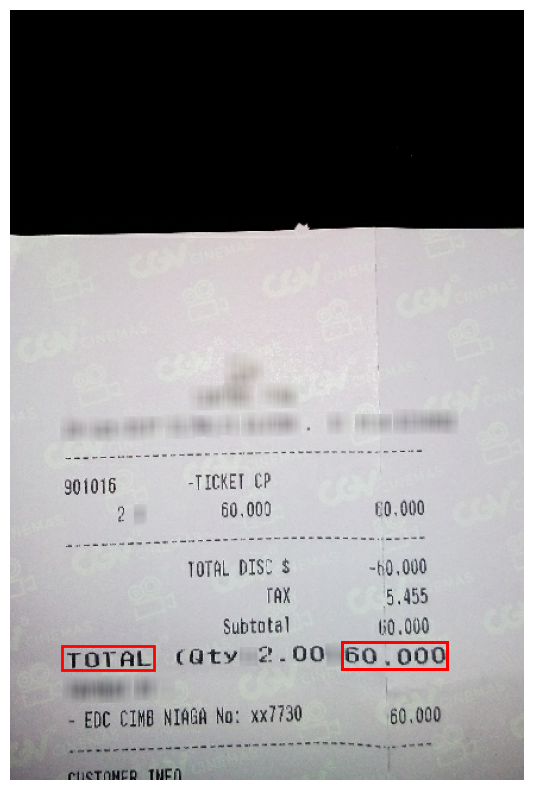

In [45]:
predicted_labels = np.array(predicted_labels)
# Filtering the bboxes to get only the ones with the predicted label = 1 ('total.total_price')
bboxes_to_plot = ground_truth_bboxes[predicted_labels == 1]
unnormalized_bboxes = [unnormalize_box(bbox, img_width, img_height) for bbox in bboxes_to_plot]

plt.figure(figsize=(10, 10))
plt.imshow(image)
# Add bounding boxes
ax = plt.gca()
for bbox in unnormalized_bboxes:
    # Extract coordinates: (x_min, y_min, x_max, y_max)
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min

    # Add a rectangle for the bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis("off")
plt.show()

## Testing with the The ExpressExpense SRD

In [47]:
# Downloading the Dataset
!wget https://expressexpense.com/large-receipt-image-dataset-SRD.zip
!unzip  /kaggle/working/large-receipt-image-dataset-SRD.zip -d /kaggle/working/datareceipts/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-12-10 16:18:35--  https://expressexpense.com/large-receipt-image-dataset-SRD.zip
Resolving expressexpense.com (expressexpense.com)... 104.26.4.208, 104.26.5.208, 172.67.69.49, ...
Connecting to expressexpense.com (expressexpense.com)|104.26.4.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19230342 (18M) [application/zip]
Saving to: 'large-receipt-image-dataset-SRD.zip.1'

large-receipt-image 100%[===================>]  18.34M  --.-KB/s    in 0.1s    

2024-12-10 16:18:35 (147 MB/s) - 'large-receipt-image-dataset-SRD.zip.1' saved [19230342/19230342]



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Archive:  /kaggle/working/large-receipt-image-dataset-SRD.zip
  inflating: /kaggle/working/datareceipts/1078-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1085-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1197-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1008-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1134-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1056-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1144-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1026-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1158-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1128-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1176-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1014-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1099-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1106-receipt.jpg  
  inflating: /kaggle/working/datareceipts/1064-receipt.jpg  
  inflating: /kaggle/wo

In [48]:
# Loading the model that had the best f1 score in the validation phase
model_inference = AutoModelForTokenClassification.from_pretrained('/kaggle/working/layoutlmv3-finetuned/checkpoint-1000')

In [49]:
model_inference.to(device)

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

**With this dataset, we only have images. To prepare them for our model, we need to extract the OCR data from each image. This process was accomplished using the pytesseract library. The library helps us extract the words, their corresponding bounding boxes from the images. After obtaining these components, we preprocess them to fit the format required by our model. This preprocessed data, including the words and bounding boxes, are then provided to our model to predict the labels**

In [56]:
def prepare_image(image_path, processor):
  """
  Preprocesses the image for input into the model, extracting OCR results and normalizing the bounding boxes.

  Args:
      image_path (str): The path to the image file.
      processor (AutoProcessor): The LayoutLMv3 processor used to preprocess the image and its data.

  Returns:
      dict: A dictionary of preprocessed inputs ready for model inference.
      PIL.Image: The original image.
  """
  image = Image.open(image_path).convert('RGB')

  image_np = np.array(image)
  height, width = image_np.shape[:2]
  ocr_results = pytesseract.image_to_data(image_np, output_type=pytesseract.Output.DICT)

  words = []
  bboxes = []
  for i in range(len(ocr_results['text'])):
    text = ocr_results['text'][i].strip()
    if len(text) > 0:
      x, y, w, h = (ocr_results['left'][i], ocr_results['top'][i],
                    ocr_results['width'][i], ocr_results['height'][i])
      bbox = [int(1000 * (x / width)), int(1000 * (y / height)), int(1000 * ((x + w) / width)), int(1000 * ((y + h) / height))]
      words.append(text)
      bboxes.append(bbox)
  print(words)
  inputs = processor(image, words, boxes=bboxes, truncation=True, padding='max_length', \
                      return_tensors='pt')
  return inputs, image

In [57]:
def predict_and_visualize(image_path, model, processor, device):
  """
  Predicts and visualizes the model's output on a given image.

  Args:
      image_path (str): The path to the image file.
      model (nn.Module): The trained model for prediction.
      processor (AutoProcessor): The LayoutLMv3 processor used to preprocess the image and its data.
      device (torch.device): The device on which to perform computations (CPU or GPU).

  Returns:
      None
  """
  inputs, raw_image = prepare_image(image_path, processor)
  for key, value in inputs.items():
    inputs[key] = value.to(device)

  with torch.no_grad():
    outputs = model(**inputs)

  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

  # Map predictions to labels
  labels = [id2label[label_id] for label_id in predictions if label_id != -100]
  # Get bounding boxes
  bboxes = inputs['bbox'].cpu().numpy().squeeze(0)
  words = processor.tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().cpu().numpy())
  
  unnormalized_bboxes = [unnormalize_box(bbox, raw_image.size[0], raw_image.size[1]) for bbox in bboxes]
  # Visualize the results
  plt.figure(figsize=(10, 10))
  plt.imshow(raw_image)
  ax = plt.gca()

  for word, bbox, label in zip(words, unnormalized_bboxes, labels):
    if label == 'total.total_price':
      # Draw bounding box
      x_min, y_min, x_max, y_max = bbox
      ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                  edgecolor='red', fill=False, linewidth=2))

  plt.axis('off')
  plt.show()

**The cell below selects three random images from the dataset and plots them with their predicted bounding boxes**

['(734)236-4033', 'Server:', 'Jasmine', '&', '12/19', '8:02', 'AY', 'Check', '#7', 'Table', '23', 'Apple', 'French', 'Toast', '$7.99', 'Coffee', 'ee)', 'subtotal', 'Tax', 'Total', '7,99', 'early', 'bird', 'breakfast', 'special', 'Nonday-', 'Friday', '7am', '~', '8am', 'River', 'village', 'kayaking', 'now', 'open', 'Sunday-Thursday', '7', ':00am-8;00pm', 'Friday/Saturday', '7;00am-9:00Pm', 'Pay', 'at', 'the', 'cash', 'register', '~', 'Thank', 'you!', '!']


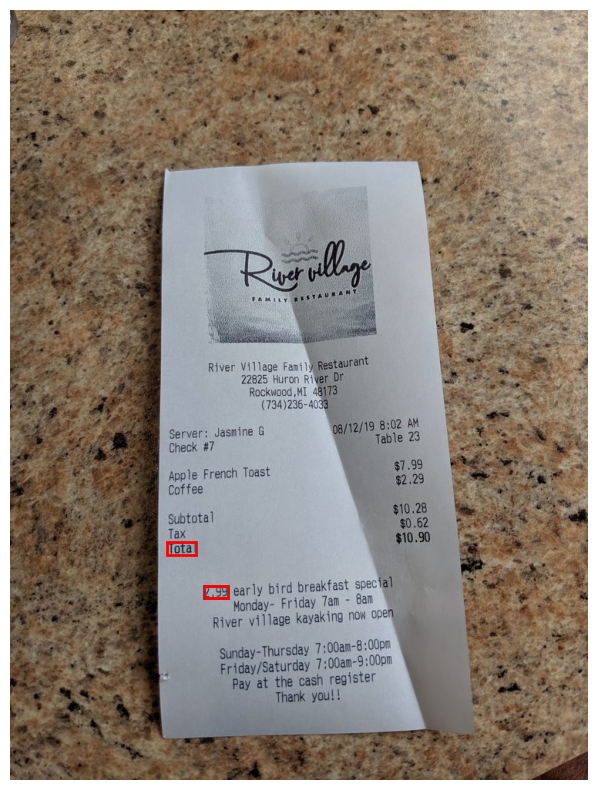

['COLUMBUS', 'RESTAURANT', '736', 'OCEAN', 'DRIVE', 'MIAMI', 'BEACH,', 'FL', '33139', 'TEL:', '786-275-6944', 'TABLE', '94', 'S', 'GUESTS', 'Gustavo', '2', 'FBD', 'BLUE', 'NARGARI', '55.00', '11000!', '1', 'CHEESE', 'BURGER', '4.4', '4', 'CHICKEN', 'MARSALA', '18.91', 'TAX', 'and.', 'SERUICE', 'Det', 'ail', 'TE', 'ARTICLES', 'Tax', 'Total', '|', 'SALES', 'TAX', '72', '143.00', '10.01', '153.0', '|', 'RESORT', 'TAX2Z', '|', 'SERUICE20/', 'TOTAL', '184.47', 'SATURDAY', '01-27-2048', '03:59PM', 'Key', '42-Haitr:', '12-POS', 'PLEASE', 'RATE', 'US', 'SO', 'ME', 'CAN', 'FOOD:', 'iad', 'we', '6', 'Ce', 'el', '2', '3', '4', '5', 'oO', 'qMBIANCE:', '12345', '6']


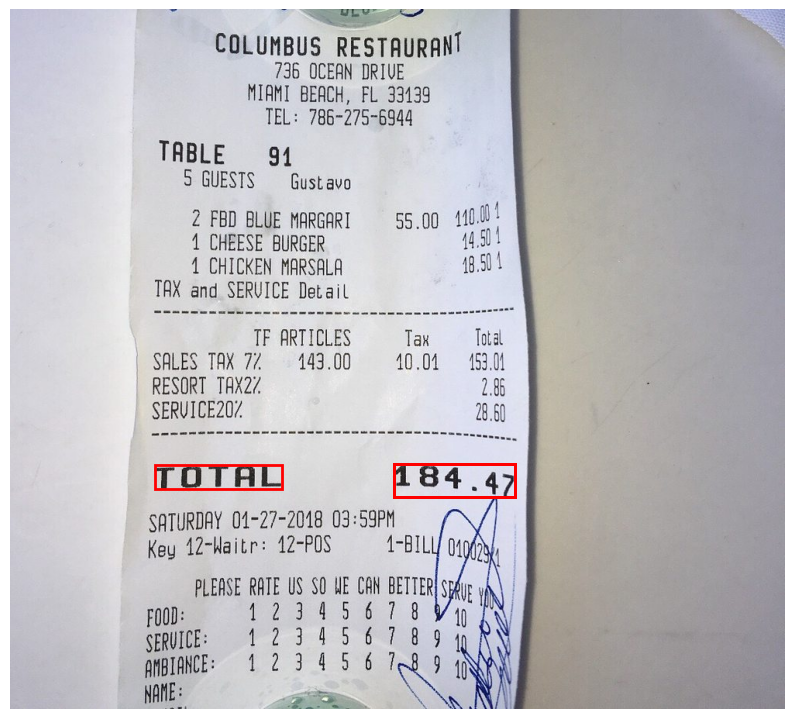

['SunayE4949-0', 'thane', '626-55-9580', '25', '§', 'Fait', 'Oaks', 'Ave', 'Pasadena,', 'Ch,', '91108', 'Served', 'by:', '41', '5/1/2019', '2:25:97', 'pa', 'fern', '-Transt', 'Wa-zstecs', '*', 'Pron', '196', '$11.93', 'Mey', '2Fllow', '11.88']


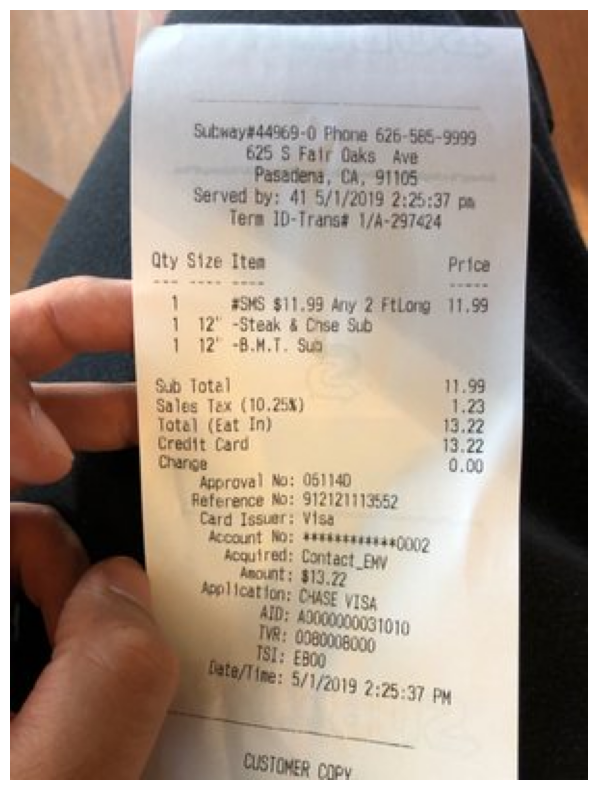

In [60]:
image_paths = glob.glob('/kaggle/working/datareceipts/*.jpg')
random_images = random.sample(image_paths, 3)

for image_path in random_images:
    predict_and_visualize(image_path, model_inference, processor, device)

**As observed from the output of words detected in the images using OCR with pytesseract, if the total amount is present in this list, our model detects it as expected. Conversely, if the total amount is not in this list, the model does not detect it, which is logical since, from the model's perspective, the amount does not exist.**

## Conclusion

**In this notebook, I fine-tuned LayoutLMv3 to detect the total price in receipts using the CORDv2 dataset. The dataset was split into three subsets: training, validation, and testing. The model was trained using the training dataset, and its performance was evaluated on the validation dataset. When tested on the test dataset, it achieved an F1 score of 97%.**

**Next, I tested the model using the ExpressExpense SRD dataset. Since this dataset required text extraction, I used OCR to process the images and provide the model with the necessary information. When the OCR process successfully extracted the amount, the model accurately identified it. However, if the amount was not extracted during the OCR phase, the model was unable to detect it.**